<a href="https://colab.research.google.com/github/akashsonowal/office-room-occupancy-detection/blob/main/room_occupancy_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install scikit-plot

**Importing necessary libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, accuracy_score, auc
from sklearn import preprocessing
import plotly.graph_objs as go
import plotly.offline as py
import statsmodels as stm

**Reading file**

In [5]:
path = '/content/drive/MyDrive/Projects/05. Room Occupancy Classification using Environmental Factors/datatest.csv'
dataset = pd.read_csv(path)
dataset.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2/2/2015 14:19,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2/2/2015 14:19,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2/2/2015 14:21,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2/2/2015 14:22,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2/2/2015 14:23,23.7540,26.200,488.600000,779.000000,0.004767,1


In [6]:
dataset = dataset.drop(['date'], axis = 1)

In [7]:
dataset.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.7000,26.272,585.200000,749.200000,0.004764,1
1,23.7180,26.290,578.400000,760.400000,0.004773,1
2,23.7300,26.230,572.666667,769.666667,0.004765,1
3,23.7225,26.125,493.750000,774.750000,0.004744,1
4,23.7540,26.200,488.600000,779.000000,0.004767,1


In [8]:
dataset.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


**Correlation Matrix**

In [9]:
dataset.corr()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
Temperature,1.000000,-0.156964,0.688571,0.449989,0.205280,0.555610
Humidity,-0.156964,1.000000,-0.029459,0.299746,0.932724,0.046240
Light,0.688571,-0.029459,1.000000,0.448105,0.223329,0.914850
CO2,0.449989,0.299746,0.448105,1.000000,0.477965,0.501582
HumidityRatio,0.205280,0.932724,0.223329,0.477965,1.000000,0.257324
Occupancy,0.555610,0.046240,0.914850,0.501582,0.257324,1.000000


**Plots**

In [10]:
D = dataset[(dataset["Occupancy"] != 0)]
H = dataset[(dataset["Occupancy"] == 0)]

In [11]:
#------------COUNT-----------------------
def target_count():
    trace = go.Bar( x = dataset['Occupancy'].value_counts().values.tolist(), 
                    y = ['Not Occupied','Occupied' ], 
                    orientation = 'h', 
                    text = dataset['Occupancy'].value_counts().values.tolist(), 
                    textfont = dict(size = 15),
                    textposition = 'auto',
                    opacity = 0.8,marker = dict(
                    color = ['lightskyblue', 'gold'],
                    line = dict(color = '#000000',width=1.5)))
    layout = dict(title =  'Count of Occupancy variable')
    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)
    
#------------PERCENTAGE-------------------
def target_percent():
    trace = go.Pie(labels = ['Not Occupied','Occupied'], values = dataset['Occupancy'].value_counts(), 
                   textfont = dict(size = 15), opacity = 0.8,
                   marker = dict(colors = ['lightskyblue', 'gold'], 
                               line = dict(color = '#000000', width = 1.5)))
    layout = dict(title =  'Distribution of Occupancy variable')
    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [12]:
target_count()
target_percent()

**Train Test Split**

In [13]:
X = dataset.iloc[:, :5]
Y = dataset.iloc[:, 5]

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2)

In [15]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

**Feature Scaling Training Data** 

$\frac{X-min}{max-min}$

In [16]:
x = X_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_train_scale = pd.DataFrame(x_scaled)

In [17]:
col_names = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
X_train_scale.columns = col_names

In [18]:
X_train_scale = sm.add_constant(X_train_scale)

**Linear Probability Model**

**Model Application**

In [19]:
X_LPM = X_train_scale.copy()

In [20]:
LPM_1 = sm.OLS(Y_train, X_LPM)
result_LPM1 = LPM_1.fit()
result_LPM1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Occupancy   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                 1.348e+04
Date:                Sun, 15 Aug 2021   Prob (F-statistic):               0.00
Time:                        04:05:32   Log-Likelihood:                 4718.0
No. Observations:               10280   AIC:                            -9424.
Df Residuals:                   10274   BIC:                            -9381.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5862      0.023     25.421      0.000       0.541       0.631
Temperature      -1.6111      0.053    -30.347      0.000      -1.715      -1.507
Humidity         -3.1245      0.131    -23.805      0.000      -3.382      -2.867
Light             3.0580      0.016    191.033      0.000       3.027       3.089
CO2               0.2122      0.011     19.385      0.000       0.191       0.234
HumidityRatio     3.4820      0.145     23.936      0.000       3.197       3.767
==============================================================================
Omnibus:                     8690.358   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           629223.869
Skew:                          -3.638   Prob(JB):                         0.00
Kurtosis:                      40.631   Cond. No.                         170.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Observation : All variables are significant**

**Variable Inflation Factor (VIF) calculation**

In [21]:
def calculate_vif(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['vif'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['vif'] = round(vif['vif'],2)
    vif = vif.sort_values(by='vif', ascending=False)
    print(vif)

In [22]:
calculate_vif(X_LPM)

        Features     vif
5  HumidityRatio  377.82
2       Humidity  362.15
0          const  233.66
1    Temperature   47.62
3          Light    1.98
4            CO2    1.86


**Observation :: HumidityRatio is having high multicollinearity, so dropping it.**

In [23]:
X_LPM = X_LPM.drop(['HumidityRatio'], axis = 1)

**Building another model after dropping HumidityRatio**

In [24]:
LPM_2 = sm.OLS(Y_train, X_LPM)
result_LPM2 = LPM_2.fit()
result_LPM2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Occupancy   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 1.583e+04
Date:                Sun, 15 Aug 2021   Prob (F-statistic):               0.00
Time:                        04:06:34   Log-Likelihood:                 4439.0
No. Observations:               10280   AIC:                            -8868.
Df Residuals:                   10275   BIC:                            -8832.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0492      0.005      8.978      0.000       0.038       0.060
Temperature    -0.3695      0.012    -31.798      0.000      -0.392      -0.347
Humidity        0.0119      0.008      1.508      0.132      -0.004       0.027
Light           3.0713      0.016    186.848      0.000       3.039       3.104
CO2             0.3190      0.010     31.050      0.000       0.299       0.339
==============================================================================
Omnibus:                     8429.740   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           535538.328
Skew:                          -3.506   Prob(JB):                         0.00
Kurtosis:                      37.657   Cond. No.                         14.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Observation : Humidity has p-value > 0.05, therefore it is insignificant, dropping it**

In [25]:
X_LPM = X_LPM.drop(['Humidity'], axis = 1)

**Building another model after dropping Humidity**

In [26]:
LPM_3 = sm.OLS(Y_train, X_LPM)
result_LPM3 = LPM_3.fit()
result_LPM3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Occupancy   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 2.110e+04
Date:                Sun, 15 Aug 2021   Prob (F-statistic):               0.00
Time:                        04:06:45   Log-Likelihood:                 4437.9
No. Observations:               10280   AIC:                            -8868.
Df Residuals:                   10276   BIC:                            -8839.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0556      0.003     16.002      0.000       0.049       0.062
Temperature    -0.3745      0.011    -33.631      0.000      -0.396      -0.353
Light           3.0720      0.016    186.941      0.000       3.040       3.104
CO2             0.3252      0.009     34.560      0.000       0.307       0.344
==============================================================================
Omnibus:                     8447.635   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           540685.291
Skew:                          -3.516   Prob(JB):                         0.00
Kurtosis:                      37.826   Cond. No.                         12.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Observation : All variables are significant**

**Variable Inflation Factor (VIF) calculation**

In [27]:
calculate_vif(X_LPM)

      Features   vif
0        const  5.02
1  Temperature  1.98
2        Light  1.98
3          CO2  1.30


**High multicollinearity between variables is absent**

**Final Linear Probability Model**

In [28]:
X_LPM_colnames = ['Temperature', 'Light', 'CO2']

In [29]:
X_train_LPM = X_train.copy()
X_train_LPM = X_train_LPM[X_LPM_colnames]
X_train_LPM = sm.add_constant(X_train_LPM)

In [30]:
LPM_final = sm.OLS(Y_train, X_train_LPM)
result_LPM_final = LPM_final.fit()
result_LPM_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Occupancy   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 2.110e+04
Date:                Sun, 15 Aug 2021   Prob (F-statistic):               0.00
Time:                        04:07:05   Log-Likelihood:                 4437.9
No. Observations:               10280   AIC:                            -8868.
Df Residuals:                   10276   BIC:                            -8839.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2945      0.042     31.055      0.000       1.213       1.376
Temperature    -0.0695      0.002    -33.631      0.000      -0.074      -0.065
Light           0.0019   1.04e-05    186.941      0.000       0.002       0.002
CO2             0.0002   5.66e-06     34.560      0.000       0.000       0.000
==============================================================================
Omnibus:                     8447.635   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           540685.291
Skew:                          -3.516   Prob(JB):                         0.00
Kurtosis:                      37.826   Cond. No.                     2.09e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Best fit Linear Probability model is:** 
Y = 1.2830 - 0.0688 * Temperature + 0.002 * Light + 0.0002 * CO2

**Evalution of Results**

**1. ROC Curve**

In [31]:
X_test_LPM = X_test.copy()
X_test_LPM = X_test_LPM[X_LPM_colnames]
X_test_LPM = sm.add_constant(X_test_LPM)

In [32]:
def draw_roc_curve(actual, probs):
    fpr, tpr, thresholds = roc_curve(actual, probs)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [33]:
Y_LPM_probs = result_LPM_final.predict(X_test_LPM)
Y_LPM_probs = Y_LPM_probs.to_numpy()
Y_actual = Y_test.to_numpy()

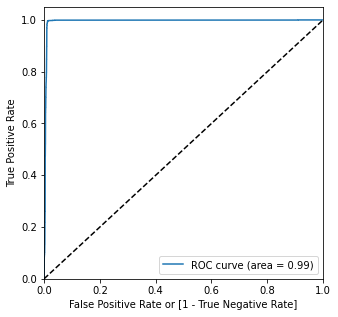

In [34]:
draw_roc_curve(Y_actual, Y_LPM_probs)

**2. Confusion Matrix**

In [35]:
Y_pred_LPM = result_LPM_final.predict(X_test_LPM)

In [36]:
for i in range(len(Y_pred_LPM)):
    if Y_pred_LPM.iloc[i] >= 0.5:
        Y_pred_LPM.iloc[i] = 1
    else:
        Y_pred_LPM.iloc[i] = 0

In [37]:
conf_mat_LPM = confusion_matrix(Y_test, Y_pred_LPM)
conf_mat_LPM

array([[7751,  138],
       [   6, 2385]])

In [38]:
print('Test Sensitivity : ', conf_mat_LPM[1,1] / (conf_mat_LPM[1,1] + conf_mat_LPM[1,0]))
print('Test Specificity : ', conf_mat_LPM[0,0] / (conf_mat_LPM[0,0] + conf_mat_LPM[0,1]))
print('True Positive Rate : ', conf_mat_LPM[1,1] / (conf_mat_LPM[1,1] + conf_mat_LPM[1,0]))
print('False Positive Rate : ', 1 - (conf_mat_LPM[0,0] / (conf_mat_LPM[0,0] + conf_mat_LPM[0,1])))

Test Sensitivity :  0.9974905897114178
Test Specificity :  0.9825072886297376
True Positive Rate :  0.9974905897114178
False Positive Rate :  0.017492711370262426


In [39]:
accuracy = (conf_mat_LPM[0, 0] + conf_mat_LPM[1, 1]) / np.sum(conf_mat_LPM)
accuracy

0.9859922178988327

In [40]:
print(classification_report(Y_test, Y_pred_LPM))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7889
           1       0.95      1.00      0.97      2391

    accuracy                           0.99     10280
   macro avg       0.97      0.99      0.98     10280
weighted avg       0.99      0.99      0.99     10280



**Probit Model**

**Model Application**

In [41]:
X_Probit = X_train_scale.copy()

In [42]:
Probit_1 = sm.Probit(Y_train, X_Probit)
result_Probit1 = Probit_1.fit()
result_Probit1.summary()

Optimization terminated successfully.
         Current function value: 0.061510
         Iterations 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              Occupancy   No. Observations:                10280
Model:                         Probit   Df Residuals:                    10274
Method:                           MLE   Df Model:                            5
Date:                Sun, 15 Aug 2021   Pseudo R-squ.:                  0.8858
Time:                        04:08:04   Log-Likelihood:                -632.32
converged:                       True   LL-Null:                       -5537.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2812      0.861      0.327      0.744      -1.406       1.968
Temperature     -11.0801      1.802     -6.148      0.000     -14.612      -7.548
Humidity        -20.3687      4.562     -4.465      0.000     -29.311     -11.427
Light            18.4545      0.463     39.882      0.000      17.548      19.361
CO2               2.6960      0.272      9.899      0.000       2.162       3.230
HumidityRatio    22.7599      4.821      4.721      0.000      13.310      32.210
=================================================================================

Possibly complete quasi-separation: A fraction 0.29 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

**Observation :: All varibles are significant**

**Variable Inflation Factor (VIF) calculation**

In [43]:
calculate_vif(X_Probit)

        Features     vif
5  HumidityRatio  377.82
2       Humidity  362.15
0          const  233.66
1    Temperature   47.62
3          Light    1.98
4            CO2    1.86


**Observation :: HumidityRatio is having high multicollinearity, so dropping it.**

In [44]:
X_Probit = X_Probit.drop(['HumidityRatio'], axis = 1)

**Building Another Model**

In [45]:
Probit_2 = sm.Probit(Y_train, X_Probit)
result_Probit2 = Probit_2.fit()
result_Probit2.summary()

Optimization terminated successfully.
         Current function value: 0.062625
         Iterations 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              Occupancy   No. Observations:                10280
Model:                         Probit   Df Residuals:                    10275
Method:                           MLE   Df Model:                            4
Date:                Sun, 15 Aug 2021   Pseudo R-squ.:                  0.8837
Time:                        04:08:27   Log-Likelihood:                -643.79
converged:                       True   LL-Null:                       -5537.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.8401      0.186    -20.644      0.000      -4.205      -3.475
Temperature    -2.6995      0.260    -10.400      0.000      -3.208      -2.191
Humidity        1.1990      0.229      5.241      0.000       0.751       1.647
Light          18.9558      0.464     40.873      0.000      18.047      19.865
CO2             2.8925      0.261     11.095      0.000       2.381       3.403
===============================================================================

Possibly complete quasi-separation: A fraction 0.33 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

**Observation : All variables are significant**

**Variable Inflation Factor (VIF) calculation**

In [46]:
calculate_vif(X_Probit)

      Features    vif
0        const  12.49
1  Temperature   2.16
3        Light   1.98
4          CO2   1.55
2     Humidity   1.24


**High multicollinearity between variables is absent**

**Final Probit Model**

In [47]:
X_Probit_colnames = ['Temperature', 'Humidity', 'Light', 'CO2']

In [48]:
X_train_Probit = X_train.copy()
X_train_Probit = X_train_Probit[X_Probit_colnames]
X_train_Probit = sm.add_constant(X_train_Probit)

In [49]:
Probit_final = sm.Probit(Y_train, X_train_Probit)
result_Probit_final = Probit_final.fit()
result_Probit_final.summary()

Optimization terminated successfully.
         Current function value: 0.062625
         Iterations 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              Occupancy   No. Observations:                10280
Model:                         Probit   Df Residuals:                    10275
Method:                           MLE   Df Model:                            4
Date:                Sun, 15 Aug 2021   Pseudo R-squ.:                  0.8837
Time:                        04:08:56   Log-Likelihood:                -643.79
converged:                       True   LL-Null:                       -5537.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.0669      1.015      4.007      0.000       2.078       6.056
Temperature    -0.5008      0.048    -10.400      0.000      -0.595      -0.406
Humidity        0.0528      0.010      5.241      0.000       0.033       0.073
Light           0.0120      0.000     40.873      0.000       0.011       0.013
CO2             0.0017      0.000     11.095      0.000       0.001       0.002
===============================================================================

Possibly complete quasi-separation: A fraction 0.33 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

**Best fit Probit model is:** Y = Φ(z)

z = 4.0622 - 0.4871 * Temperature + 0.0407 * Humidity + 0.0122 * Light + 0.0018 * CO2

**Evalution of Results**

**1. ROC Curve**

In [50]:
X_test_Probit = X_test.copy()
X_test_Probit = X_test_Probit[X_Probit_colnames]
X_test_Probit = sm.add_constant(X_test_Probit)

In [51]:
Y_probit_probs = result_Probit_final.predict(X_test_Probit)
Y_probit_probs = Y_probit_probs.to_numpy()
Y_actual = Y_test.to_numpy()

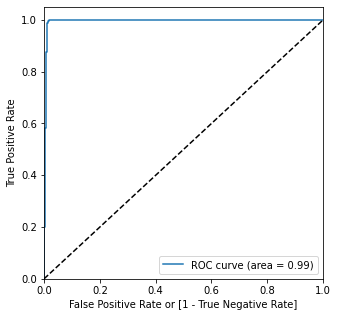

In [52]:
draw_roc_curve(Y_actual, Y_probit_probs)

**2. Confusion Matrix**

In [53]:
Y_pred_Probit = result_Probit_final.predict(X_test_Probit)

In [54]:
for i in range(len(Y_pred_Probit)):
    if Y_pred_Probit.iloc[i] >= 0.5:
        Y_pred_Probit.iloc[i] = 1
    else:
        Y_pred_Probit.iloc[i] = 0

In [55]:
conf_mat_Probit = confusion_matrix(Y_test, Y_pred_Probit)
conf_mat_Probit

array([[7791,   98],
       [  10, 2381]])

In [56]:
print('Test Sensitivity : ', conf_mat_Probit[1,1] / (conf_mat_Probit[1,1] + conf_mat_Probit[1,0]))
print('Test Specificity : ', conf_mat_Probit[0,0] / (conf_mat_Probit[0,0] + conf_mat_Probit[0,1]))
print('True Positive Rate : ', conf_mat_Probit[1,1] / (conf_mat_Probit[1,1] + conf_mat_Probit[1,0]))
print('False Positive Rate : ', 1 - (conf_mat_Probit[0,0] / (conf_mat_Probit[0,0] + conf_mat_Probit[0,1])))

Test Sensitivity :  0.9958176495190297
Test Specificity :  0.9875776397515528
True Positive Rate :  0.9958176495190297
False Positive Rate :  0.012422360248447228


In [57]:
accuracy = (conf_mat_Probit[0, 0] + conf_mat_Probit[1, 1]) / np.sum(conf_mat_Probit)
accuracy

0.9894941634241246

In [58]:
print(classification_report(Y_test, Y_pred_Probit))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7889
           1       0.96      1.00      0.98      2391

    accuracy                           0.99     10280
   macro avg       0.98      0.99      0.99     10280
weighted avg       0.99      0.99      0.99     10280



**Logit Model**

**Model Application**

In [59]:
X_Logit = X_train_scale.copy()

In [60]:
Logit_1 = sm.Logit(Y_train, X_Logit)
result_Logit1 = Logit_1.fit()
result_Logit1.summary()

Optimization terminated successfully.
         Current function value: 0.056298
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Occupancy   No. Observations:                10280
Model:                          Logit   Df Residuals:                    10274
Method:                           MLE   Df Model:                            5
Date:                Sun, 15 Aug 2021   Pseudo R-squ.:                  0.8955
Time:                        04:09:28   Log-Likelihood:                -578.74
converged:                       True   LL-Null:                       -5537.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.8141      1.852     -0.440      0.660      -4.443       2.815
Temperature     -18.8409      3.880     -4.855      0.000     -26.446     -11.235
Humidity        -35.1803      9.753     -3.607      0.000     -54.295     -16.065
Light            35.7095      1.171     30.494      0.000      33.414      38.005
CO2               5.6906      0.594      9.577      0.000       4.526       6.855
HumidityRatio    39.3738     10.306      3.820      0.000      19.173      59.574
=================================================================================
"""

**Observation :: All variables are significant**

**Variable Inflation Factor (VIF) calculation**

In [61]:
calculate_vif(X_Logit)

        Features     vif
5  HumidityRatio  377.82
2       Humidity  362.15
0          const  233.66
1    Temperature   47.62
3          Light    1.98
4            CO2    1.86


**Observation :: HumidityRatio is having high multicollinearity, so dropping it.**

In [62]:
X_Logit = X_Logit.drop(['HumidityRatio'], axis = 1)

**Building Another Model**

In [63]:
Logit_2 = sm.Logit(Y_train, X_Logit)
result_Logit2 = Logit_2.fit()
result_Logit2.summary()

Optimization terminated successfully.
         Current function value: 0.057055
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Occupancy   No. Observations:                10280
Model:                          Logit   Df Residuals:                    10275
Method:                           MLE   Df Model:                            4
Date:                Sun, 15 Aug 2021   Pseudo R-squ.:                  0.8941
Time:                        04:09:36   Log-Likelihood:                -586.52
converged:                       True   LL-Null:                       -5537.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -7.8926      0.400    -19.713      0.000      -8.677      -7.108
Temperature    -4.3494      0.543     -8.006      0.000      -5.414      -3.285
Humidity        2.1135      0.465      4.542      0.000       1.201       3.026
Light          36.5936      1.177     31.103      0.000      34.288      38.900
CO2             5.9122      0.578     10.229      0.000       4.779       7.045
===============================================================================
"""

**Observation : All variables are significant**

**Variable Inflation Factor (VIF) calculation**

In [64]:
calculate_vif(X_Logit)

      Features    vif
0        const  12.49
1  Temperature   2.16
3        Light   1.98
4          CO2   1.55
2     Humidity   1.24


**High multicollinearity between variables is absent**

**Final Logit Model**

In [65]:
X_Logit_colnames = ['Temperature', 'Humidity', 'Light', 'CO2']

In [66]:
X_train_Logit = X_train.copy()
X_train_Logit = X_train_Logit[X_Logit_colnames]
X_train_Logit = sm.add_constant(X_train_Logit)

In [67]:
Logit_final = sm.Logit(Y_train, X_train_Logit)
result_Logit_final = Logit_final.fit()
result_Logit_final.summary()

Optimization terminated successfully.
         Current function value: 0.057055
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Occupancy   No. Observations:                10280
Model:                          Logit   Df Residuals:                    10275
Method:                           MLE   Df Model:                            4
Date:                Sun, 15 Aug 2021   Pseudo R-squ.:                  0.8941
Time:                        04:09:46   Log-Likelihood:                -586.52
converged:                       True   LL-Null:                       -5537.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.3999      2.085      2.110      0.035       0.313       8.487
Temperature    -0.8069      0.101     -8.006      0.000      -1.004      -0.609
Humidity        0.0931      0.020      4.542      0.000       0.053       0.133
Light           0.0231      0.001     31.103      0.000       0.022       0.025
CO2             0.0036      0.000     10.229      0.000       0.003       0.004
===============================================================================
"""

**Best fit Logit model is,**
Y = 1 / (1 + exp(-z))

z = 4.3288 - 0.7863 * Temperature + 0.0762 * Humidity + 0.0236 * Light + 0.0036 * CO2

**Evalution of Results**

**1. ROC Curve**

In [68]:
X_test_Logit = X_test.copy()
X_test_Logit = X_test_Logit[X_Logit_colnames]
X_test_Logit = sm.add_constant(X_test_Logit)

In [69]:
Y_logit_probs = result_Logit_final.predict(X_test_Logit)
Y_logit_probs = Y_logit_probs.to_numpy()
Y_actual = Y_test.to_numpy()

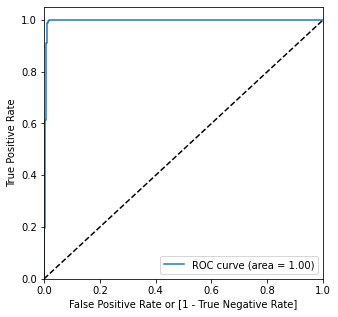

In [70]:
draw_roc_curve(Y_actual, Y_logit_probs)

**2. Confusion Matrix**

In [71]:
Y_pred_Logit = result_Logit_final.predict(X_test_Logit)

In [72]:
for i in range(len(Y_pred_Logit)):
    if Y_pred_Logit.iloc[i] >= 0.5:
        Y_pred_Logit.iloc[i] = 1
    else:
        Y_pred_Logit.iloc[i] = 0

In [73]:
conf_mat_Logit = confusion_matrix(Y_test, Y_pred_Logit)
conf_mat_Logit

array([[7791,   98],
       [  11, 2380]])

In [74]:
print('Test Sensitivity : ', conf_mat_Logit[1,1] / (conf_mat_Logit[1,1] + conf_mat_Logit[1,0]))
print('Test Specificity : ', conf_mat_Logit[0,0] / (conf_mat_Logit[0,0] + conf_mat_Logit[0,1]))
print('True Positive Rate : ', conf_mat_Logit[1,1] / (conf_mat_Logit[1,1] + conf_mat_Logit[1,0]))
print('False Positive Rate : ', 1 - (conf_mat_Logit[0,0] / (conf_mat_Logit[0,0] + conf_mat_Logit[0,1])))

Test Sensitivity :  0.9953994144709327
Test Specificity :  0.9875776397515528
True Positive Rate :  0.9953994144709327
False Positive Rate :  0.012422360248447228


In [75]:
accuracy = (conf_mat_Logit[0, 0] + conf_mat_Logit[1, 1]) / np.sum(conf_mat_Logit)
accuracy

0.9893968871595331

In [76]:
print(classification_report(Y_test, Y_pred_Logit))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7889
           1       0.96      1.00      0.98      2391

    accuracy                           0.99     10280
   macro avg       0.98      0.99      0.99     10280
weighted avg       0.99      0.99      0.99     10280

